In [1]:
import pandas as pd
import numpy as np
snoqualmie = pd.read_csv('data/set1.txt', skiprows=1, header=None, delim_whitespace=True)
#rows are 36 years between 1948-1983 and columns are 366 days accounting for leap years
print(snoqualmie.shape)
snoqualmie.head(10)

(36, 366)


,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,136,100,16,80,10,66,88,38,1,87,...,0,0,0,0,0,0,0,49,114,17.0
1,17,14,0,0,1,11,90,6,0,0,...,107,29,97,47,245,121,72,27,41,NaN
2,1,35,13,13,18,122,22,25,8,48,...,85,43,20,4,40,10,5,93,23,NaN
3,34,183,11,20,11,0,9,1,0,3,...,0,0,0,0,4,19,37,19,0,NaN
4,0,0,2,1,2,7,11,2,37,21,...,10,5,0,0,0,0,43,35,15,13.0
5,2,124,51,2,0,41,113,177,143,5,...,15,0,0,19,2,53,3,7,17,NaN
6,59,48,44,121,130,90,42,33,13,0,...,63,51,22,1,0,26,61,109,26,NaN
7,32,36,0,4,16,0,0,0,0,0,...,27,10,12,72,26,0,0,0,0,NaN
8,48,52,141,106,50,74,51,8,10,1,...,12,33,0,0,0,0,0,0,5,14.0
9,43,12,9,1,0,0,68,34,0,8,...,72,46,130,35,65,118,21,5,0,NaN


In [2]:
import numpy as np
from iminuit import Minuit


In [3]:
# preprocess the data...
# columns will be year, day, rainfall today, rainfall tomorrow
from itertools import cycle
rainfall_sequence = snoqualmie.values.flatten()
rainfall_sequence = rainfall_sequence[~np.isnan(rainfall_sequence)]

snoq = pd.DataFrame()
years = range(1948,1984)
days_per_year = cycle((366, 365, 365, 365))
for year_i, num_days in zip(range(len(years)), days_per_year):
    if years[year_i] == years[-1]: #last year in data
        year_vec = [int(years[year_i])]*(num_days-1)
        day_vec = range(1,num_days)
        today_rainfall = np.array(rainfall_sequence[year_i*num_days:(year_i+1)*num_days-1])
        tomorrow_rainfall = np.array(rainfall_sequence[year_i*num_days+1:(year_i+1)*num_days])
    else:
        year_vec = [int(years[year_i])]*num_days
        day_vec = range(1,num_days+1)
        today_rainfall = rainfall_sequence[year_i*num_days:(year_i+1)*num_days]
        tomorrow_rainfall = rainfall_sequence[year_i*num_days+1:(year_i+1)*num_days+1]
    rained_today = today_rainfall > 0
    rained_tomorrow = tomorrow_rainfall > 0
    yf = pd.DataFrame({'year': year_vec, 'day': day_vec, 'rained today?': rained_today, 'rained tomorrow?': rained_tomorrow,
                       'rainfall today': today_rainfall,'rainfall tomorrow':tomorrow_rainfall })
    snoq = pd.concat([snoq, yf], axis=0, ignore_index=True)

print(snoq.shape[0])
snoq.tail(15)

13148


,day,rained today?,rained tomorrow?,rainfall today,rainfall tomorrow,year
13133,350,False,True,0.0,64.0,1983
13134,351,True,True,64.0,38.0,1983
13135,352,True,True,38.0,124.0,1983
13136,353,True,True,124.0,27.0,1983
13137,354,True,False,27.0,0.0,1983
13138,355,False,True,0.0,78.0,1983
13139,356,True,True,78.0,30.0,1983
13140,357,True,True,30.0,15.0,1983
13141,358,True,False,15.0,0.0,1983
13142,359,False,False,0.0,0.0,1983


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

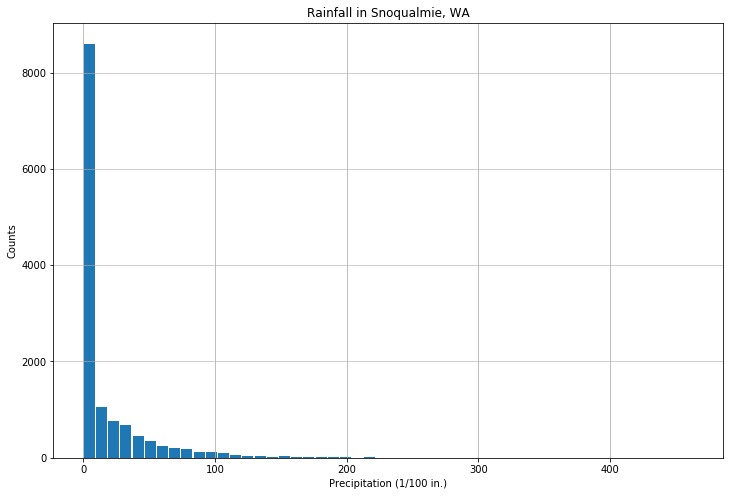

In [5]:
plt.close('all')
snoq['rainfall today'].plot.hist(bins=50, rwidth=0.9, grid=True, figsize=(12,8));
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Precipitation (1/100 in.)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

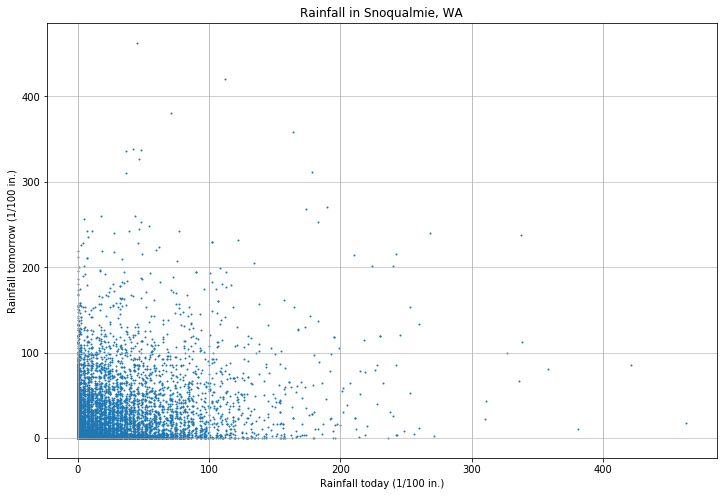

In [6]:
plt.close('all')
snoq.plot.scatter(x='rainfall today', y='rainfall tomorrow', s=1, grid=True, figsize=(12,8));
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Rainfall tomorrow (1/100 in.)')
plt.grid(axis='y', alpha=0.75)

In [7]:
# the data to use in the fit
X1 = snoq['rainfall today'].values.reshape(-1,1)
# add a column of ones at the beginning for the bias term
ones = np.ones(X1.shape[0]).reshape(-1,1)
X = np.concatenate((ones,X1), axis=1) 
print(X[:5])
n_features = X.shape[1]
# The thing we want to predict
Y = snoq['rained tomorrow?'].values.astype(int).reshape(-1,1)

[[  1. 136.]
 [  1. 100.]
 [  1.  16.]
 [  1.  80.]
 [  1.  10.]]


## Description

The $Y$ variable is binary, either zero or one. The $X$ is a range of real numbers. We want to predict $Pr(Y=1|X=x)$. $Pr(Y=0|X=x)$ will just be $1 - Pr(Y=1|X=x)$. The optimal solution at every point x is the expectation value of the variable Y, i.e. $E[Y|X=x]$.

To predict a probability distribution, the likelihood of the probability distribution (which is defined on the sample) should be maximized, or equivalently the minimum of the negative 2 log likelihood. 

$$L = \prod_i P(y_i; x_i, \theta) \qquad -2 \text{log}[L] = -2 \sum_i \text{log}[P(y_i; x_i, \theta)]$$

Since Y is only 1 or 0, we can re-write $P(y_i; x_i, \theta) = P(x_i, \theta)^{y_i}(1 - P(x_i, \theta))^{1-y_i}$

If our model is logistic regression for the binary Y, we want want the fit to be linear with respect to the log odds, i.e. $ \frac{p(x)}{1-p(x)} = \theta \cdot X$, which rewritten to be plugged into the likelihood would be 

$$ P(x_i, \theta) = \frac{1}{1 + e^{-(\theta \cdot X)}}$$ 

Thus making the -2 log likelihood is 

$$ -2 \text{log}[L] = -2 \sum_i -\text{log}(1+e^{\theta \cdot x_i}) + y_i*(\theta \cdot x_i)$$

In [8]:
# define the loss function to minimize. We are using a linear logistic model
def neg2_log_likelihood(X,Y):
    assert(len(X.shape)==2),"must be 2D array with measurements in rows and features in cols"
    assert(X.shape[0] == Y.size),"x size is {}, y size is {}. must be the same".format(X.shape[0],y.size)
    def f(theta):
        logl = 0
        linear = np.dot(X,theta.reshape(-1,1))
        logl = sum(-1.0*np.log(1+np.exp(linear)) + Y*(linear))
        return -2.0*logl
    return f

#the long way, not using matrix multiplication
#for (xi,yi) in zip(X,Y):
#    logl += -1.0*np.log(1+np.exp(np.dot(np.transpose(theta),xi))) + yi*(np.dot(np.transpose(theta),xi))

In [9]:
# Given a list of linear parameters (intercept and slopes), gives the regression curve
# Also can gives the confidence interval functions by providing the covariance matrix of the predictions
# Assumes a gaussian when creating the confidence interval
def logit_regression(theta,X=None,cov_mat=None):
    n_features = len(theta)
    cov_mat = np.eye(n_features) if cov_mat is None else cov_mat
    def f(x, cl=0):
        center = np.dot(x,theta.reshape(-1,1))
        #error propagation
        if X is None:
            variances = np.zeros(center.shape)
        else:
            variances = np.sum(np.dot(x,np.dot(cov_mat,np.transpose(x)))*np.eye(x.shape[0]), axis=1)
        std_err = (cl*np.sqrt(variances)).reshape(-1,1)
        #result
        y = 1./(1.+np.exp(-(center+std_err)))
        return y
    return f

def line_regression(theta,X=None,cov_mat=None):
    n_features = len(theta)
    cov_mat = np.eye(n_features) if cov_mat is None else cov_mat
    def f(x, cl=0):
        center = np.dot(x,theta.reshape(-1,1))
        #error propagation
        if X is None:
            variances = np.zeros(center.shape)
        else:
            variances = np.sum(np.dot(x,np.dot(cov_mat,np.transpose(x)))*np.eye(x.shape[0]), axis=1)        
            std_err = (cl*np.sqrt(variances)).reshape(-1,1)
        #result
        y = center+std_err
        return y
    return f

In [10]:
from iminuit import Minuit
# MINUIT is a suite for numerical minimization and error estimation, originally written in FORTRAN
# minimize your loss function of choice with the migrad method (gradient descent)
# This is a numerical way of estimating the minimum, 
# rather than an analytical solution like the normal equation
para_names = ['beta'+str(i) for i in range(n_features)]
snoq_likelihood = neg2_log_likelihood(X,Y)
nuit = Minuit.from_array_func(snoq_likelihood, (0.5,0.5), error=(0.1,0.1), name = tuple(para_names), errordef = 0.5)
nuit.migrad();
best_theta = np.array(nuit.values.values())
print('minimum for the sample: {}'.format(snoq_likelihood(best_theta)))
#print('likelihood: {}'.format(snoq_likelihood(np.array((best_theta[0]+.1,best_theta[1]-.1)))))

FCN = 15889.30547192165 
 TOTAL NCALL = 83 
 NCALLS = 83 
 
 
 EDM = 3.351064068066203e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.436358 
 0.0152939 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0453883 
 0.000926627 
 
 
 
 
 No

minimum for the sample: [15889.30547192]


In [11]:
#get the regression functions using the best fit estimators
sample_best_fit_curve = logit_regression(best_theta,X)
# get the xaxis and the prediction for x
xaxis = np.linspace(0,500,500).reshape(-1,1)
x_values = np.concatenate((np.ones(xaxis.size).reshape(-1,1), xaxis),axis=1)
# draw the y axis
yaxis = sample_best_fit_curve(x_values, 0)

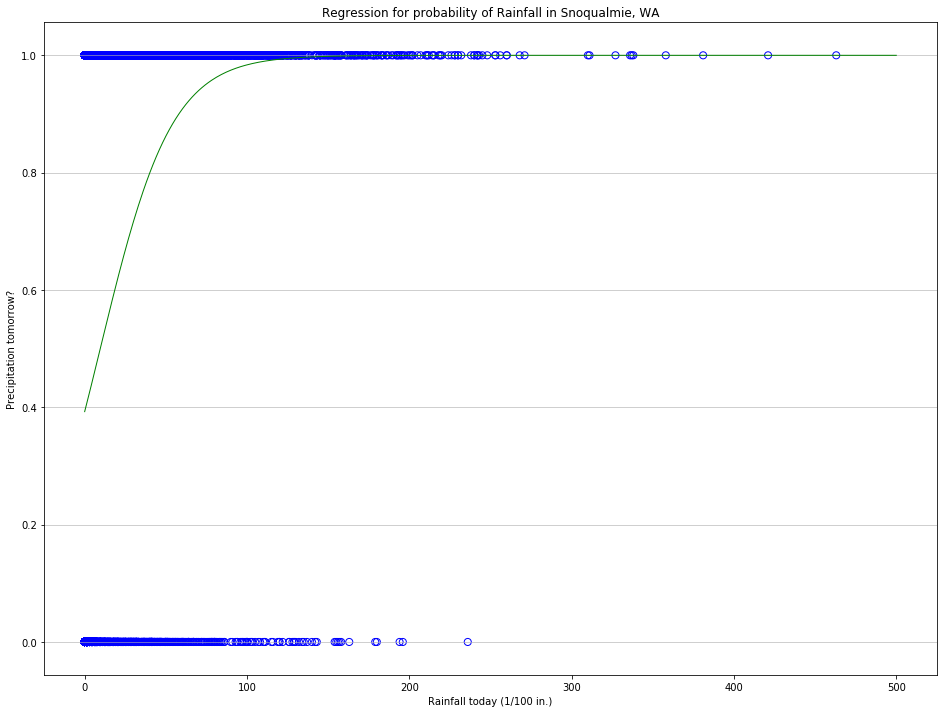

In [12]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,yaxis, linewidth=1,color='green') #regression line
plt.title('Regression for probability of Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)

# Propagating errors

To draw the confidence interval around our regression, we will use the Hessian errors, since they include the covariances of the estimators. We will get the confidence band around $E[Y|X=x]$ by using the sum of correlated random variables..

We define Z as the population parameter of the log-odds of it raining, given X=x. $B$ are the optimal parameters that maximize the likelihood when we are forced to use a linear logistic model.  

$$ Z(X=x) = \text{log}\frac{E[Y|X=x]}{1-E[Y|X=x]} = B_0 + x \cdot B $$

We do not have access to the whole population, but just the sample that was provided above. In that case we have estimated Z using the best-fit parameters $\beta_0$ and $\beta$, calculated from the maximum likelihood of our sample. We call this estimate $\hat{Z}$ and try to find the confidence band around it with the following equation:

$$ V[\hat{Z}(X=x)] = V[\sum_i x_i \beta_i] = \sum_{i=1}^n x_i^2 V[\beta_i] + \sum_{1 \leq i \lt j}^n 2 x_i x_j Cov[\beta_i, \beta_j] $$

The $x_i$ here are the features associated with each $\beta_i$, and not the individual $x$ measurements in the sample.

These confidence intervals only account for variance in the estimated parameters, and they do not account for the possible bias of the fit. i.e. the linear-logistic regression may not be the most optimal model to maximize the likelihood. These confidence intervals will not capture the uncertainty due to using a suboptimal model.

In [13]:
# Numerically calculate the hessian (for getting the correlation matrix of the errors). 
# Inverse of Hessian gives symmetric errors and assumes a multivariate gaussian distribution for the estimators
from pprint import pprint
nuit.hesse()
cov_matrix = nuit.np_matrix()
pprint(cov_matrix) 
print('std_dev b: {} \n std_dev m: {}'.format(np.sqrt(cov_matrix[0][0]),np.sqrt(cov_matrix[1][1])))

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.436358 
 0.0152933 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0453883 
 0.000926587 
 
 
 
 
 No

beta0 beta1 
 
 
 beta0 1.00 -0.48 
 
 
 beta1 -0.48 1.00

array([[ 2.33883814e-04, -6.84005393e-06],
       [-6.84005393e-06,  8.58564025e-07]])
std_dev b: 0.015293260399048316 
 std_dev m: 0.00092658730043826


In [14]:
# Can check the Hessian errors with MINOS, which utilizes profile likelihood to get the variances
# Since it uses profile likelihood, it does not give covariances.
# If the errors are comparable, then the asymptotic assumptions of the Hessian are all right
nuit.minos()
pprint(nuit.merrors)

Error,-0.015297673224241089,0.015299467236875646
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0009231702692846029,0.0009305996512600799
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{('beta0', -1.0): -0.015297673224241089,
 ('beta0', 1.0): 0.015299467236875646,
 ('beta1', -1.0): -0.0009231702692846029,
 ('beta1', 1.0): 0.0009305996512600799}


# Plot the best fit curve

In [15]:
# use the best-fit thetas to get the regression curve
sample_best_fit_curve = logit_regression(best_theta,X,cov_matrix)
# get the central value and confidence intervals from the regression curve
xaxis = np.linspace(0,500,500).reshape(-1,1)
x_values = np.concatenate((np.ones(xaxis.size).reshape(-1,1), xaxis),axis=1)
yaxis_1err = sample_best_fit_curve(x_values, 1.96)
yaxis_neg1err = sample_best_fit_curve(x_values, -1.96)

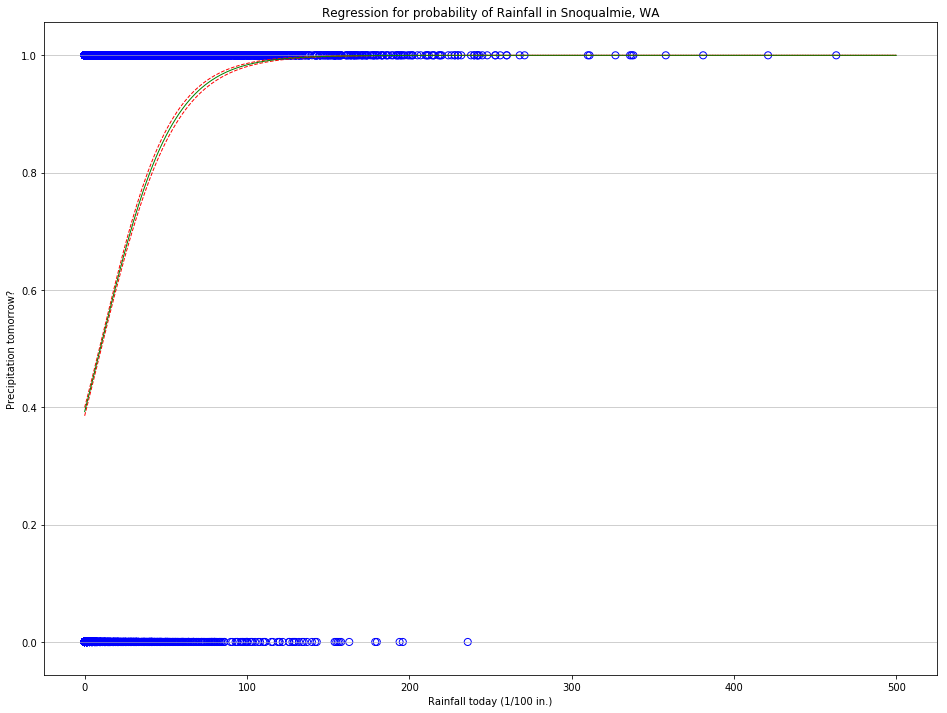

In [16]:
#plot it!
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,yaxis_1err, linewidth=1,color='red',linestyle='dashed') # 95% confidence up assuming Gaussian errors on estimators
plt.plot(xaxis,yaxis_neg1err, linewidth=1,color='red',linestyle='dashed') # 95% confidence down assuming Gaussian errors on estimators
plt.plot(xaxis,yaxis, linewidth=1,color='green') #regression line
plt.title('Regression for probability of Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)
# These confidence intervals only account for variance, they do not account for the possible bias of the fit. 
# I.e. logistic regression may not be the most optimal model to maximizes the likelihood.

# Checking for bias

We can check for bias in the parametric linear-logistic fit by doing a fit to a non-parametric logistic model and comparing their maximum likelihoods. We will stick with modeling the log-odds $Z$, but use non-parametric smoothing functions $f(x)$ and not require that they be linear in $X$. 

$$ Z(X=x) = \text{log}\frac{E[Y|X=x]}{1-E[Y|X=x]} = a + \sum_i^p f_i(x_i) $$

$p$ are the number of features.

Going to just use a general additive model (GAM) package to do the fit. pyGAM uses penalized B splines as the feature functions $f(X_i)$. From the pyGAM website: "GAMs extend generalized linear models by allowing non-linear functions of features while maintaining additivity. Since the model is additive, it is easy to examine the effect of each $X_i$ on $Y$ individually while holding all other predictors constant."

## Get best-fit from the GAM model

In [17]:
from pygam import LogisticGAM, s
import warnings
warnings.filterwarnings('ignore')

gam = LogisticGAM(s(0)+s(1), fit_intercept=False).fit(X, Y) # I've included the intercept in X[0]
gam.summary()
gam_likelihood = -2.*gam.loglikelihood(X, Y)
print('-2 log likelihood for GAM: {:.3f}'.format(gam_likelihood))


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      7.6278
Link Function:                        LogitLink Log Likelihood:                                 -7484.1159
Number of Samples:                        13148 AIC:                                            14983.4873
                                                AICc:                                              14983.5
                                                UBRE:                                               3.1401
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1772
Feature Function                  Lam

## Plot the GAM model to the sample and overlay with linear model

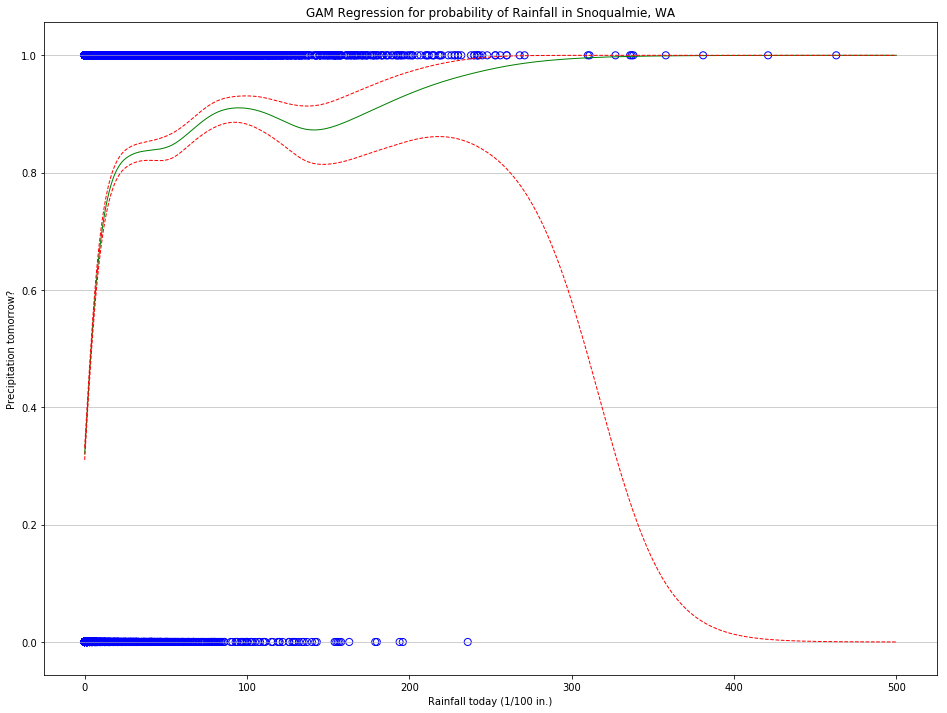

In [18]:
gam_axis = gam.predict_mu(x_values)
gam_ci = gam.confidence_intervals(x_values,0.95)
#plot the fit
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,gam_axis, linewidth=1,color='green') #regression line
plt.plot(xaxis,gam_ci, linewidth=1,color='red',linestyle='dashed') #regression line
plt.title('GAM Regression for probability of Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)

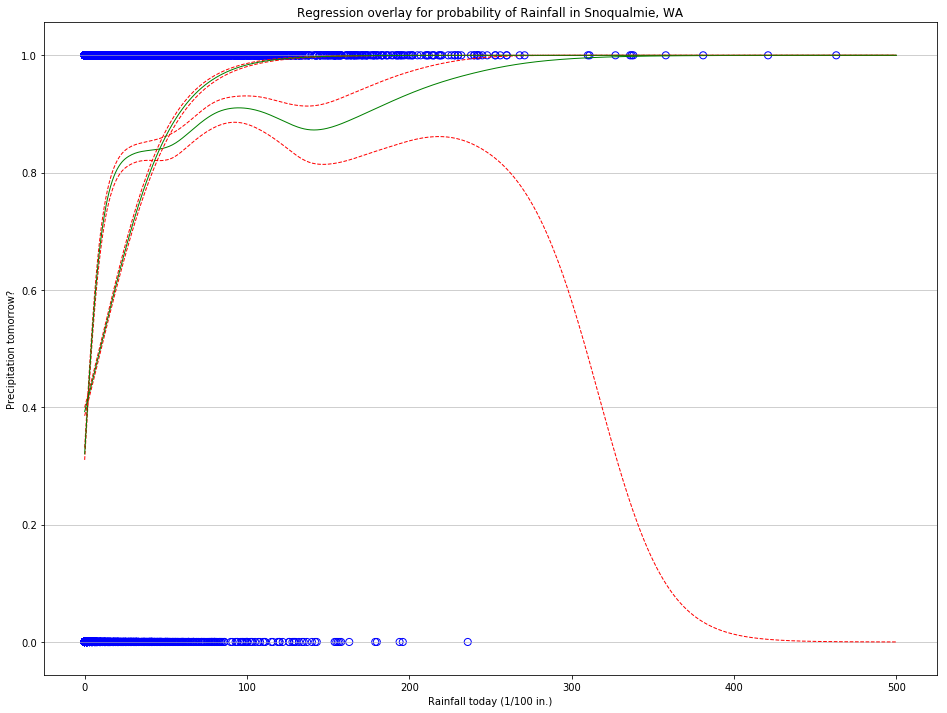

In [19]:
#Overlay the two
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,gam_ci, linewidth=1,color='red',linestyle='dashed') #gam fit
plt.plot(xaxis,gam_axis, linewidth=1,color='green') #gam fit
plt.plot(xaxis,yaxis_1err, linewidth=1,color='red',linestyle='dashed') # linear fit
plt.plot(xaxis,yaxis_neg1err, linewidth=1,color='red',linestyle='dashed') # linear fit
plt.plot(xaxis,yaxis, linewidth=1,color='green') # linear fit
plt.title('Regression overlay for probability of Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)

## Simulating from the linear fit to calculate bias

Visually, the two regressions look quite different. The GAM has more degrees of freedom and so can be more "wiggly" than the log-linear model. The question is though, would those extra degrees of freedom go to zero with a larger sample size (making the GAM more like the linear model) or is the GAM capturing other characteristics of the feature that the linear model is ignoring? If the parametric log-linear model is optimal, then the GAM would eventually approximate it. 

We can measure departure from optimality by taking the difference of the minimum -2 log likelihoods from the two models. If this difference is "too big", then the linear model is biased and not the optimal model (i.e. we can state, within a certain confidence, that the non-parametric GAM is fitting to a more optimal underlying model given the features X). 

Rather than assuming some asymptotic behavior of the difference of the -2 log likelihood (i.e. that it follows a $\chi^2$ distribution with degrees of freedom dof_GAM-dof_linear), we will instead simulate many -2 log likelihood differences asssuming the log-linear model is correct, and assume that the difference between the simulated samples will be characteristic of the difference between the actual sample (if the log-linear model is indeed optimal).

We will also compare this to the measured $\chi^2$.

In [20]:
# Give the original X coordinates with the log-linear function and best-fit thetas 
# to generate the predicted probabilities.
# Use the predicted probabilities in a binomial distribution to get a new set of Y results
def generate_new_sample(theta, x_ori,seed=0):
    predict = logit_regression(theta)
    probs = predict(x_ori)
    np.random.seed(seed)
    y = np.random.binomial(1, probs, probs.shape)
    return y

def calculate_2ll_diff(x,y):
    # Get the best fit linear model
    likelihood_func = neg2_log_likelihood(x,y)
    fitter = Minuit.from_array_func(likelihood_func, [0.5]*x.shape[1], error=[0.1]*x.shape[1], errordef = 0.5, print_level=0)
    fitter.migrad();
    fit_theta = np.array(fitter.values.values())
    linear_2ll = likelihood_func(fit_theta)
    # get the best fit GAM model
    gam_sim = LogisticGAM(fit_intercept=False).fit(x, y)
    gam_2ll = -2.*gam_sim.loglikelihood(x, y)
    #return the difference in -2 log likelihood
    return (linear_2ll-gam_2ll) 


In [21]:
import concurrent.futures, time, random
# simulate the models many times to get a lot of likelihood differences
# This may take a long time to run
n_sim = 1000
likelihood_differences = []

def model(seed):
    y_sim = generate_new_sample(best_theta, X, seed)
    result = calculate_2ll_diff(X,y_sim)
    return result

seeds = random.sample(range(n_sim*5),n_sim)

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    for i, result in zip(range(len(seeds)), executor.map(model,seeds)):
        likelihood_differences.append(result)
        print('.',end ="")
end = time.time()
print('done')

print('Time elapsed: {} min'.format((end-start)/60))
likelihood_differences = np.array(likelihood_differences)
print('n samples: {}'.format(len(likelihood_differences)))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [22]:
from probfit import UnbinnedLH, chisquared
unbinned_likelihood = UnbinnedLH(chisquared, likelihood_differences[0])
minuit = Minuit(unbinned_likelihood, k=2, error_k=0.1, errordef=0.5)
minuit.migrad()
dof = minuit.values.values()[0]

FCN = 1.5062881968556923 
 TOTAL NCALL = 15 
 NCALLS = 15 
 
 
 EDM = 2.1574341514276e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 k 
 2.6743 
 1.91448 
 
 
 
 
 No

estimated GAM dof for sample: 7.627752044399316
dof from histogram fit: 2.674295043842201


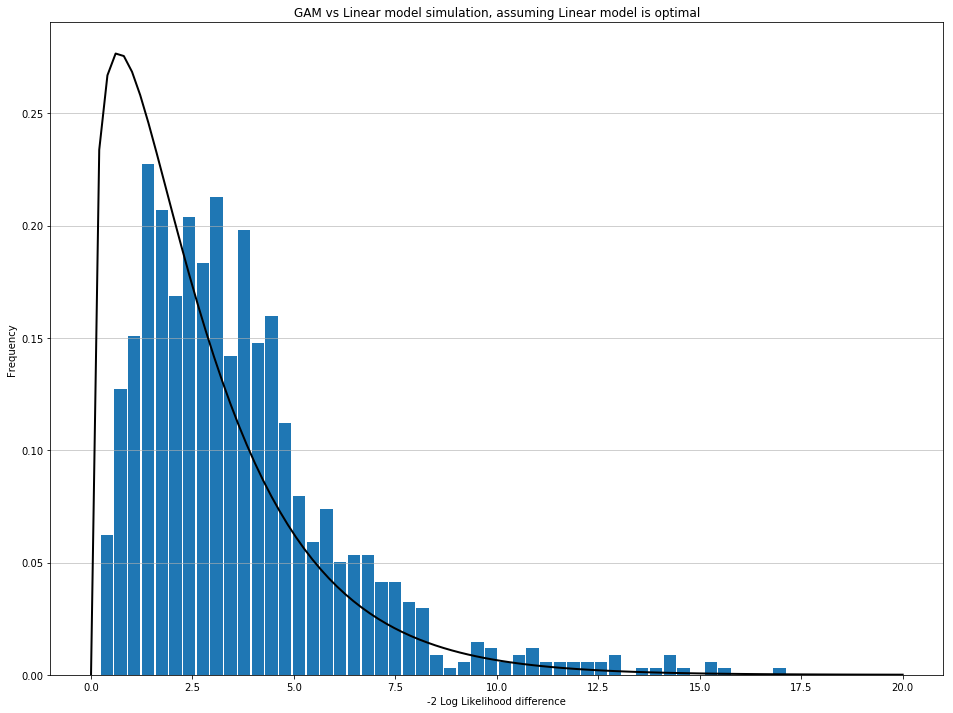

In [23]:
#create a chi2 distribution
from scipy.stats import chi2
estimate_gam_dof = sum(gam.statistics_['edof_per_coef'])
print('estimated GAM dof for sample: {}'.format(estimate_gam_dof))
print('dof from histogram fit: {}'.format(dof))
rv = chi2(dof)
x_chi2 = np.linspace(0,20,100)
# plot a histogram of the differences in likelihood, with the original sample one overlayed
plt.close('all')
plt.figure(figsize=(16,12))
plt.hist(likelihood_differences, bins=50, rwidth=0.9, normed=True)
plt.plot(x_chi2, rv.pdf(x_chi2), 'k-', lw=2)
plt.title('GAM vs Linear model simulation, assuming Linear model is optimal')
plt.xlabel('-2 Log Likelihood difference')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [24]:
# calculate a p-value from the histogram.
sample_difference = calculate_2ll_diff(X,Y)
gt_sample = likelihood_differences >= sample_difference
p_value = sum(gt_sample)/sum(likelihood_differences)
print('average difference of simulation is: {}'.format(sum(likelihood_differences)/len(likelihood_differences)))
print('sample difference is: {:.2f}'.format(sample_difference[0]))
print('p-value is: {}'.format(p_value[0]))
# calculate a p-value using the asymptotic assumptions

average difference of simulation is: [3.70392241]
sample difference is: 921.07
p-value is: 0.0


# Add another feature to the logistic fit

Now we are going to add a simple binary feature to the regression about whether it rained today or not. The information is implicitly already in `rainfall_today`, but making the fact that it rained today (even if it was just a little) an explicit True/False feature may improve the logistic model and get a more optimal sample minimum likelihood value. 

In [25]:
# add another columns of data to use in the fit
X2 = snoq['rained today?'].values.astype(int).reshape(-1,1)
Xextend = np.concatenate((X,X2), axis=1)
print(Xextend[9:15])
n_features_extend = Xextend.shape[1]

[[ 1. 87.  1.]
 [ 1.  8.  1.]
 [ 1.  4.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


In [26]:
para_names_extend = ['beta'+str(i) for i in range(n_features_extend)]
snoq_likelihood_extended = neg2_log_likelihood(Xextend,Y)
nuit_extended = Minuit.from_array_func(snoq_likelihood_extended, (0.5,0.5,0.5), error=(0.1,0.1,0.1), name = tuple(para_names_extend), errordef = 0.5)
nuit_extended.migrad();
better_theta = np.array(nuit_extended.values.values())
print('minimum likelihood for the sample with two features: {}'.format(snoq_likelihood_extended(better_theta)))
print('minimum likelihood for the sample with one feature: {}'.format(snoq_likelihood(best_theta)))
nuit_extended.hesse()
cov_matrix_extended = nuit_extended.np_matrix()

FCN = 14937.495756275111 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 1.9263761589108245e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.914042 
 0.0197678 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0208574 
 0.000869501 
 
 
 
 
 No 
 
 
 2 
 beta2 
 1.43782 
 0.0330424 
 
 
 
 
 No

minimum likelihood for the sample with two features: [14937.49575628]
minimum likelihood for the sample with one feature: [15889.30547192]


Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 beta0 
 -0.914042 
 0.0198141 
 
 
 
 
 No 
 
 
 1 
 beta1 
 0.0208574 
 0.000869793 
 
 
 
 
 No 
 
 
 2 
 beta2 
 1.43782 
 0.0332898 
 
 
 
 
 No

beta0 beta1 beta2 
 
 
 beta0 1.00 -0.00 -0.59 
 
 
 beta1 -0.00 1.00 -0.54 
 
 
 beta2 -0.59 -0.54 1.00

In [27]:
#get the regression function using the best fit estimators
sample_better_fit_curve = logit_regression(better_theta,Xextend,cov_matrix_extended)
# get the xaxis and the prediction for x and that it will rain (X2=1 everywhere)
x2_values = np.concatenate((x_values, np.ones(xaxis.size).reshape(-1,1)),axis=1)
# draw the y axis
y2_axis = sample_better_fit_curve(x2_values, 0)
y2_axis_1err = sample_better_fit_curve(x2_values, 1.96)
y2_axis_neg1err = sample_better_fit_curve(x2_values, -1.96)

In [28]:
#create a new GAM fit including the new feature
gam2 = LogisticGAM(s(0)+s(1)+s(2), fit_intercept=False).fit(Xextend, Y) 
gam2_axis = gam2.predict_mu(x2_values)
gam2_ci = gam2.confidence_intervals(x2_values,0.95)
gam2.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      8.4699
Link Function:                        LogitLink Log Likelihood:                                 -7404.4918
Number of Samples:                        13148 AIC:                                            14825.9235
                                                AICc:                                           14825.9385
                                                UBRE:                                               3.1281
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1859
Feature Function                  Lam

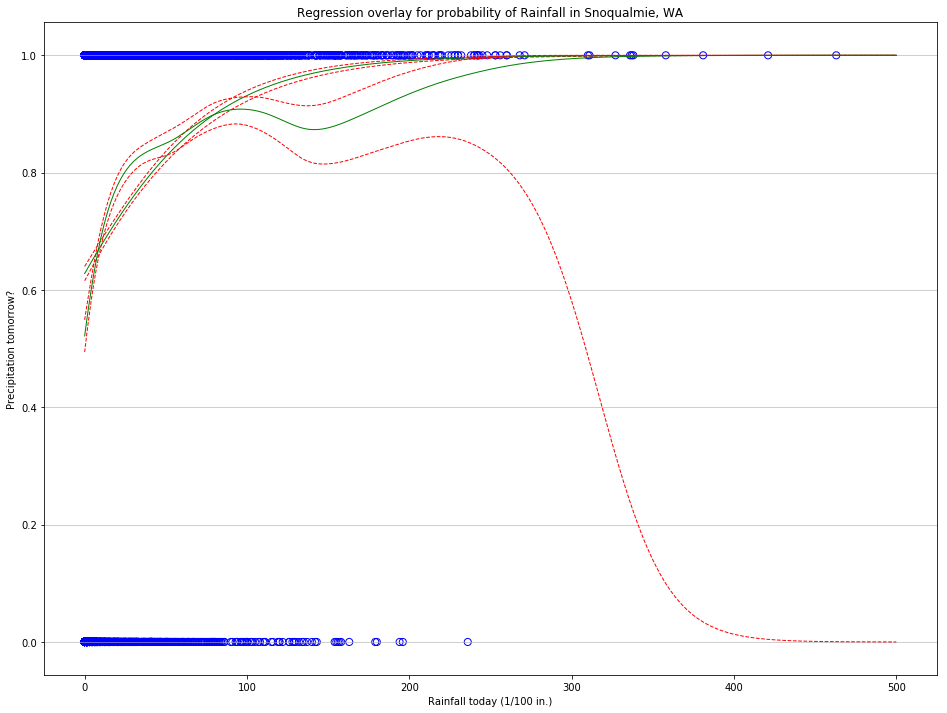

In [29]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,y2_axis_1err, linewidth=1,color='red',linestyle='dashed') # linear fit with new feature
plt.plot(xaxis,y2_axis_neg1err, linewidth=1,color='red',linestyle='dashed') # linear fit with new feature
plt.plot(xaxis,y2_axis, linewidth=1,color='green') # linear fit with new feature
plt.plot(xaxis,gam2_ci, linewidth=1,color='red',linestyle='dashed') #gam fit
plt.plot(xaxis,gam2_axis, linewidth=1,color='green') #gam fit
plt.title('Regression overlay for probability of Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)

In [30]:
print('-2 log likelihood for linear log: {:.3f}'.format(snoq_likelihood_extended(better_theta)[0]))
print('-2 log likelihood for GAM: {:.3f}'.format(-2.*gam2.loglikelihood(Xextend, Y)))
sample_difference_new = calculate_2ll_diff(Xextend, Y)
print('sample difference: {:.3f}'.format(sample_difference_new[0]))

-2 log likelihood for linear log: 14937.496
-2 log likelihood for GAM: 14808.984
sample difference: 128.512


In [31]:
new_likelihood_differences = []

def new_model(seed):
    y_sim = generate_new_sample(better_theta, Xextend, seed)
    result = calculate_2ll_diff(Xextend,y_sim)
    return result

new_seeds = random.sample(range(n_sim*5),n_sim)

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    for i, result in zip(range(len(new_seeds)), executor.map(new_model,new_seeds)):
        new_likelihood_differences.append(result)
        print('.',end ="")
end = time.time()
print('done')

print('Time elapsed: {} min'.format((end-start)/60))
new_likelihood_differences = np.array(new_likelihood_differences)
print('n samples: {}'.format(len(new_likelihood_differences)))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [32]:
unbinned_likelihood_2 = UnbinnedLH(chisquared, new_likelihood_differences[0])
minuit_2 = Minuit(unbinned_likelihood_2, k=2, error_k=0.1, errordef=0.5)
minuit_2.migrad()
new_dof = minuit_2.values.values()[0]

FCN = 1.873358206523774 
 TOTAL NCALL = 22 
 NCALLS = 22 
 
 
 EDM = 5.87796307663307e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 k 
 4.4877 
 2.67451 
 
 
 
 
 No

estimated GAM dof from sample: 8.469903701676635
estimate dof from fit: 4.487695650372525


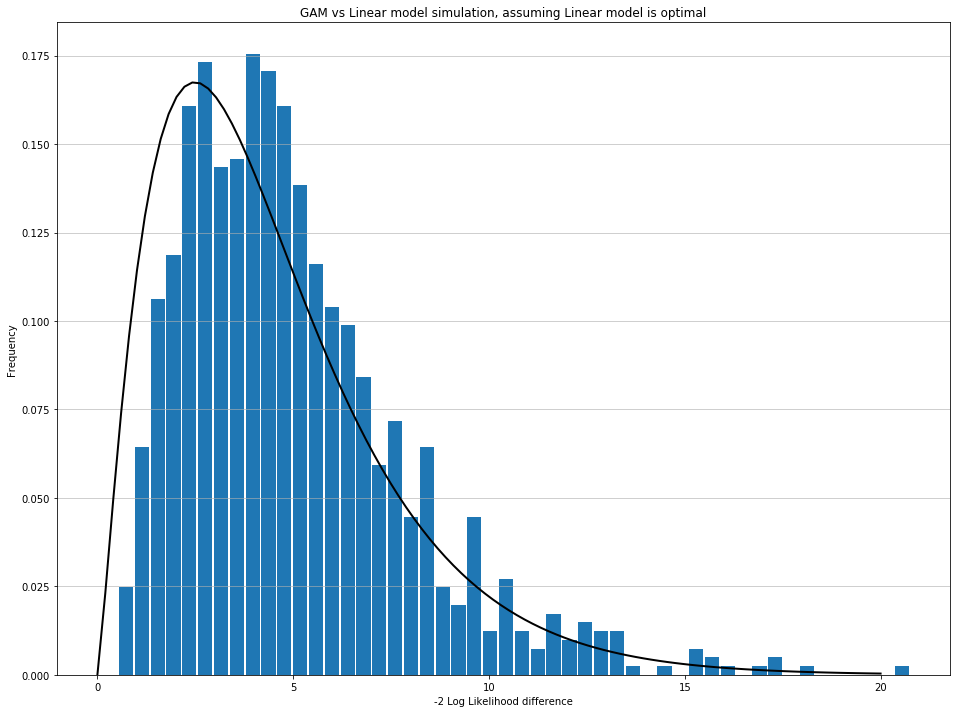

In [33]:
estimate_gam2_dof = sum(gam2.statistics_['edof_per_coef'])
print('estimated GAM dof from sample: {}'.format(estimate_gam2_dof))
print('estimate dof from fit: {}'.format(new_dof))
rv = chi2(new_dof)
x_chi2 = np.linspace(0,20,100)
# plot a histogram of the differences in likelihood, with the original sample one overlayed
plt.close('all')
plt.figure(figsize=(16,12))
plt.hist(new_likelihood_differences, bins=50, rwidth=0.9, normed=True)
plt.plot(x_chi2, rv.pdf(x_chi2), 'k-', lw=2)
plt.title('GAM vs Linear model simulation, assuming Linear model is optimal')
plt.xlabel('-2 Log Likelihood difference')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [34]:
# calculate a p-value from the histogram.
gt_sample = new_likelihood_differences >= sample_difference_new
new_p_value = sum(gt_sample)/sum(new_likelihood_differences)
print('sample difference is: {:.2f}'.format(sample_difference_new[0]))
print('average difference is: {}'.format(sum(new_likelihood_differences)/len(new_likelihood_differences)))
print('p-value is: {}'.format(new_p_value[0]))
# predict using asymptotic assumptions

sample difference is: 128.51
average difference is: [5.00475438]
p-value is: 0.0


# Calibration

The logistic model gives predicted probabilities. What is it compared to the actual fractions observed in the sample? How far does it deviate?


In [35]:
#The actual fraction in the sample that has 'rainfall tomorrow' = 1 if 'rainfall today' = 0
no_rain_today = snoq['rained today?'] == False
yes_rain_tomo = snoq['rained tomorrow?'] == True
frac = sum(no_rain_today&yes_rain_tomo)/sum(no_rain_today)
print(frac)
#The predicted probability from the logistic function of 'rainfall tomorrow' = 1 if 'rainfall today' = 0
x_test = np.array([1, 0, 0]).reshape(1,-1)
prediction = sample_better_fit_curve(x_test)
print(prediction[0])
#Exactly the same

0.2861731170708206
[0.28617345]


In [36]:
# It got that one right at least! But for the entire range from prob 0 to 1 how does it do? 
# transform the probability regression into a calibration regressionå
# Make a new data frame that is organized by amount of rainfall, and the fraction of days that had rain tomorrow
calib_df  = snoq[["rainfall today","rained tomorrow?"]].groupby("rainfall today").agg(['count','sum'])
calib_df = calib_df['rained tomorrow?']
calib_df['bias'] = 1
calib_df.index.name = 'rainfall today'
calib_df.reset_index(inplace=True)
calib_df = calib_df.rename(index=str, columns={"count": "rain today count"})
calib_df['rained today?'] = (calib_df['rainfall today'] > 0).astype(int)
calib_df['rain tomorrow count'] = calib_df['sum'].astype(int)
calib_df = calib_df.drop(['sum'],axis=1)
calib_df['measured frac'] = calib_df['rain tomorrow count'].div(calib_df['rain today count'])
calib_df['predict frac'] = sample_better_fit_curve(calib_df[['bias','rainfall today','rained today?']])
calib_df['std err'] = sample_better_fit_curve(calib_df[['bias','rainfall today','rained today?']],1.)
calib_df['std err'] = calib_df['std err'] - calib_df['predict frac']
calib_df.head(15)

,rainfall today,rain today count,bias,rained today?,rain tomorrow count,measured frac,predict frac,std err
0,0.0,6227,1,0,1782,0.286173,0.286173,0.004065
1,1.0,471,1,1,232,0.492569,0.632891,0.006065
2,2.0,453,1,1,254,0.560706,0.637723,0.005903
3,3.0,329,1,1,197,0.598784,0.642528,0.005745
4,4.0,226,1,1,135,0.597345,0.647304,0.005593
5,5.0,238,1,1,154,0.647059,0.652051,0.005445
6,6.0,184,1,1,116,0.630435,0.656768,0.005303
7,7.0,158,1,1,98,0.620253,0.661454,0.005167
8,8.0,162,1,1,118,0.728395,0.666109,0.005036
9,9.0,152,1,1,112,0.736842,0.670732,0.004912


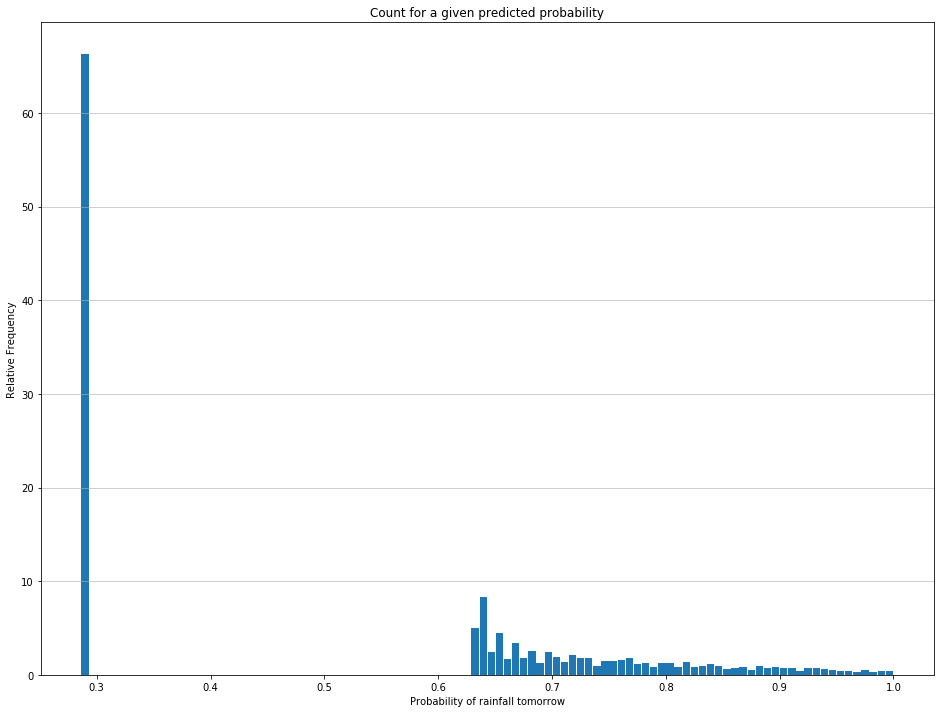

In [37]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.hist(calib_df['predict frac'],weights=calib_df['rain today count'], bins=100, rwidth=0.9, normed=True)
plt.title('Count for a given predicted probability')
plt.xlabel('Probability of rainfall tomorrow')
plt.ylabel('Relative Frequency')
plt.grid(axis='y', alpha=0.75)

In [38]:
#create a dataframe to use to plot
plot_df = pd.DataFrame()
linex = np.linspace(0,1,101)

for i in range(len(linex)-1):
    predictions = calib_df[(calib_df['predict frac'] > linex[i]) & (calib_df['predict frac'] <= linex[i+1])]
    predict_center = (linex[i]+linex[i+1])/2.
    counts = predictions['rain today count'].sum()
    if predictions.shape[0] == 0:
        predicted_mean = np.nan
        measured_mean = np.nan
        std_err_reg = np.nan
        std_err = np.nan
    else:
        predicted_mean = predictions['predict frac'].mean()
        measured_mean = predictions['measured frac'].mean()
        #propagate errors from regression - add predicted errors in quadrature to get std err of regression
        weighted_norm = np.dot(predictions['rain today count']*predictions['std err'],predictions['std err'])
        std_err_reg = np.sqrt(weighted_norm/(counts**2))
        # If you want errors around the predictions, have to include the noise error too 
        # The noise is unknown, but since we are using linear-logistic model, we assume binominal
        binomial_var = predictions['predict frac']*(1-predictions['predict frac']) #variance for a bernoulli trial
        binomial_var = ((predictions['rain today count']*binomial_var).sum())/(counts**2)
        std_err = np.sqrt(std_err_reg**2 + binomial_var)
    data = pd.DataFrame({'counts':counts,'predicted center':[predict_center],'predicted mean':[predicted_mean],
                         'measured mean':[measured_mean], 'regression std err':[std_err_reg],
                         'prediction std err': [std_err]})
    plot_df = pd.concat([plot_df, data],axis=0, ignore_index=True)
plot_df = plot_df.sort_values(by=['predicted center'])
plot_df[60:70]

,counts,measured mean,predicted center,predicted mean,prediction std err,regression std err
60,0,NaN,0.605,NaN,NaN,NaN
61,0,NaN,0.615,NaN,NaN,NaN
62,0,NaN,0.625,NaN,NaN,NaN
63,924,0.526638,0.635,0.635307,0.015837,0.000197
64,555,0.598065,0.645,0.644916,0.020320,0.000241
65,422,0.638747,0.655,0.654410,0.023156,0.000262
66,320,0.674324,0.665,0.663782,0.026409,0.000285
67,427,0.737533,0.675,0.675311,0.022669,0.000233
68,240,0.684174,0.685,0.686644,0.029945,0.000293
69,229,0.738011,0.695,0.695549,0.030406,0.000287


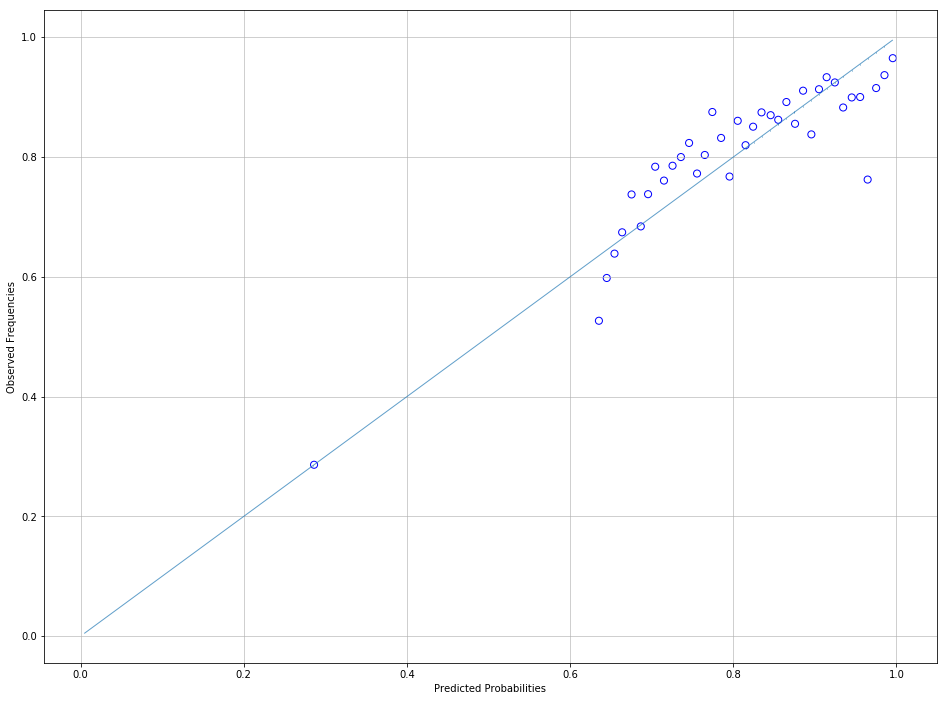

In [39]:
plt.close('all')
plt.figure(figsize=(16,12))
yerr = 1.96*plot_df['regression std err'].values
plt.errorbar(x=plot_df['predicted center'].values, y=plot_df['predicted center'].values, yerr=yerr, lw=1, alpha=0.70)
plt.scatter(x=plot_df['predicted mean'].values, y=plot_df['measured mean'].values, s=50, color='blue',marker='o',facecolors='none');
plt.xlabel('Predicted Probabilities')
plt.ylabel('Observed Frequencies')
plt.grid(axis='both', alpha=0.75)
# This only plots the error around the regression. 
# They are essentially invisible, as the log-linear regression has very little variance

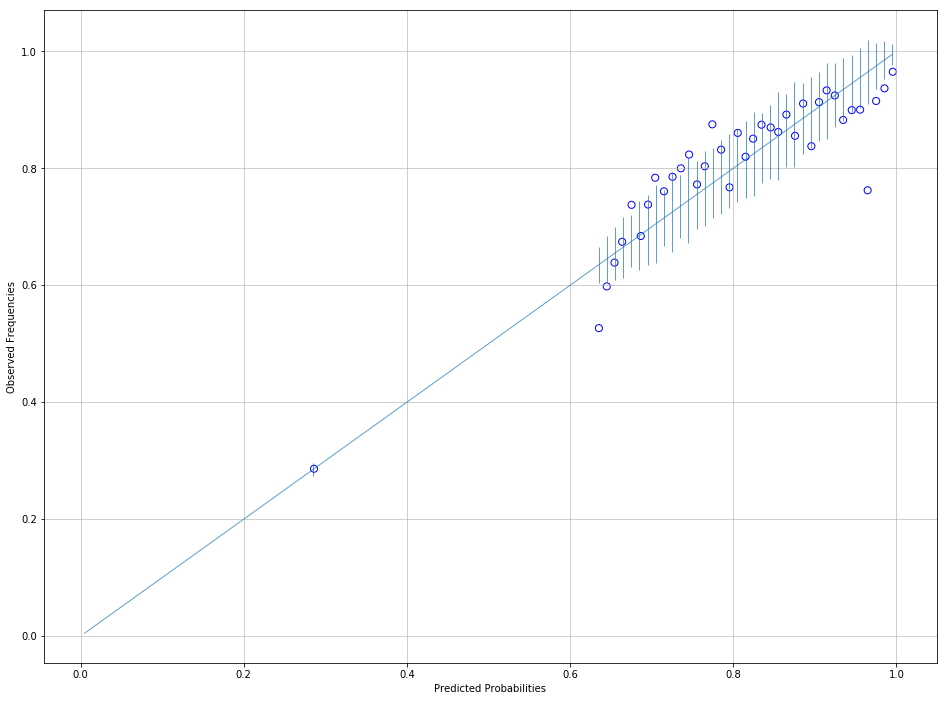

In [40]:
plt.close('all')
plt.figure(figsize=(16,12))
yerr = 1.96*plot_df['prediction std err'].values
plt.errorbar(x=plot_df['predicted center'].values, y=plot_df['predicted center'].values, yerr=yerr, lw=1, alpha=0.70)
plt.scatter(x=plot_df['predicted mean'].values, y=plot_df['measured mean'].values, s=50, color='blue',marker='o',facecolors='none');
plt.xlabel('Predicted Probabilities')
plt.ylabel('Observed Frequencies')
plt.grid(axis='both', alpha=0.75)
# Assuming the noise is binomial, this plots the error around the predicted probability